In [1]:
# import required libraries to munge data
import pandas as pd
import numpy as np

In [2]:
# import matplotlib to draw plot inside of notebook
%matplotlib inline
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
# Start from grid table
acc_table = pd.read_csv("../../log/grid_10_epoches.csv", header=0)
grid_table = acc_table

In [4]:
def select_case(table, kv, selected_dim, output, plot=False):
    subset_table = table
    x_col = selected_dim
    for k in kv:
        subset_table = subset_table[subset_table[k] == kv[k]]
    if plot:
        subset_table.plot(x=x_col, y=[output], figsize=(8, 8), kind="scatter")
        
    return (subset_table)    

In [5]:
# munge table to record best accuracy of hyperparameter vector which measured at each epochs
epoch_table = grid_table[grid_table["Measure Type"] == "epoch"]

best_list = []
filter_sizes = [1, 2, 4, 5, 6, 8, 10, 12, 14]
conv1_depths = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
conv2_depths = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
fc_depths = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
for filter_size in filter_sizes:
    for conv1_depth in conv1_depths:
        for conv2_depth in conv2_depths:
            for fc_depth in fc_depths:
                selection = {"Param1": filter_size, "Param2" : conv1_depth, "Param3" : conv2_depth, "Param4" : fc_depth}
                case = select_case(epoch_table, selection, "Step", "Metric1", False)
                best_test_error = 100 - max(case["Metric1"])
                best_case = {"Filter size" : filter_size, "Conv1 depth": conv1_depth, \
                             "Conv2 depth" : conv2_depth, "FC neurons" : fc_depth, "Best Test Error" : best_test_error}
                best_list.append(best_case)
best_table = pd.DataFrame(best_list)
best_table.describe()

,Best Test Error,Conv1 depth,Conv2 depth,FC neurons,Filter size
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,30.459949,140.600000,140.600000,140.600000,6.888889
std,38.424149,173.011462,173.011462,173.011462,4.201938
min,0.660000,2.000000,2.000000,2.000000,1.000000
25%,1.260000,8.000000,8.000000,8.000000,4.000000
50%,3.555000,48.000000,48.000000,48.000000,6.000000
75%,86.580000,256.000000,256.000000,256.000000,10.000000
max,90.200000,512.000000,512.000000,512.000000,14.000000


In [6]:
# munge table by selecting total only
measureType = "total"
total_only_table = grid_table[grid_table["Measure Type"] == measureType]
total_only_table["Test Error"] = 100 - total_only_table["Metric1"] 
total_only_table.rename(columns={"Param1": "Filter size", "Param2": "Conv1 depth", "Param3": "Conv2 depth", "Param4": "FC neurons"}, inplace=True)
total_only_table = pd.DataFrame(total_only_table[[ "Filter size", "Conv1 depth", "Conv2 depth", "FC neurons", "Elapsed Time", "Test Error"]])
total_only_table = total_only_table.sort_values(["Filter size", "Conv1 depth", "Conv2 depth", "FC neurons"], \
                                                ascending=[True, True, True, True])
total_only_table = total_only_table.reset_index(drop=True)
 
total_only_table.describe()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,Filter size,Conv1 depth,Conv2 depth,FC neurons,Elapsed Time,Test Error
count,9006.000000,9006.000000,9006.000000,9006.000000,9006.000000,9006.000000
mean,6.887964,140.747946,140.641350,140.747946,254.271663,30.813988
std,4.200790,173.053094,173.001767,173.084633,348.047396,38.804861
min,1.000000,2.000000,2.000000,2.000000,42.800000,0.670000
25%,4.000000,8.000000,8.000000,8.000000,67.700000,1.280000
50%,6.000000,64.000000,64.000000,64.000000,126.000000,3.635000
75%,10.000000,256.000000,256.000000,256.000000,290.000000,88.650000
max,14.000000,512.000000,512.000000,512.000000,3120.000000,90.200000


In [7]:
# Extract an one dimension
def get_one_dim(kv, selected_dim, output, log_x=True, log_y= True, plot=False):
    subset_table = total_only_table
    x_col = selected_dim
    for k in kv:
        subset_table = subset_table[subset_table[k] == kv[k]]
    
    if log_x: # log 2 transformation
        logscale_x = "log2(" + selected_dim + ")"
        subset_table[logscale_x] = log_scale(subset_table[selected_dim].values.tolist())
        x_col = logscale_x

    if log_y:  # log 10 transformation
        logscale_y = "log10(" + output + ")"
        subset_table[logscale_y] = log_scale(subset_table[output].values.tolist(), 10)
        output = logscale_y
        
    if plot:
        subset_table.plot(x=x_col, y=[output], figsize=(8, 8))
        
    return (subset_table)

In [8]:
merged_list = []
for best_condition in best_list:
    selection = {"Filter size": best_condition["Filter size"],\
                 "Conv1 depth" : best_condition["Conv1 depth"],\
                 "Conv2 depth" : best_condition["Conv2 depth"],\
                 "FC neurons" : best_condition["FC neurons"]}
    row = select_case(total_only_table, selection, "Elapsed Time", "Test Error")
    items = row.values.tolist()
    
    if len(items) >= 1:
        item = items[0]
        best_condition["Elapsed Time"] = item[4]
        if item[5] > best_condition["Best Test Error"]:
            best_condition["Best Test Error"] = item[5]
    else:
        print (selection) # print out missing conditions
        best_condition["Elapsed Time"] = "NA"
    merged_list.append(best_condition)
merged_table = pd.DataFrame(merged_list)
merged_table.head(10)

,Best Test Error,Conv1 depth,Conv2 depth,Elapsed Time,FC neurons,Filter size
0,82.18,2,2,44.0,2,1
1,41.33,2,2,44.0,4,1
2,39.99,2,2,44.0,8,1
3,34.06,2,2,43.6,16,1
4,88.65,2,2,44.1,32,1
5,88.65,2,2,44.0,64,1
6,88.65,2,2,44.0,128,1
7,89.72,2,2,44.2,256,1
8,89.72,2,2,44.3,384,1
9,89.72,2,2,43.7,512,1


,Best Test Error,Conv1 depth,Conv2 depth,Elapsed Time,FC neurons,Filter size
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,30.831714,140.600000,140.600000,254.021289,140.600000,6.888889
std,38.797384,173.011462,173.011462,347.948270,173.011462,4.201938
min,0.680000,2.000000,2.000000,42.800000,2.000000,1.000000
25%,1.290000,8.000000,8.000000,67.675000,8.000000,4.000000
50%,3.670000,48.000000,48.000000,126.000000,48.000000,6.000000
75%,88.650000,256.000000,256.000000,290.000000,256.000000,10.000000
max,90.200000,512.000000,512.000000,3120.000000,512.000000,14.000000


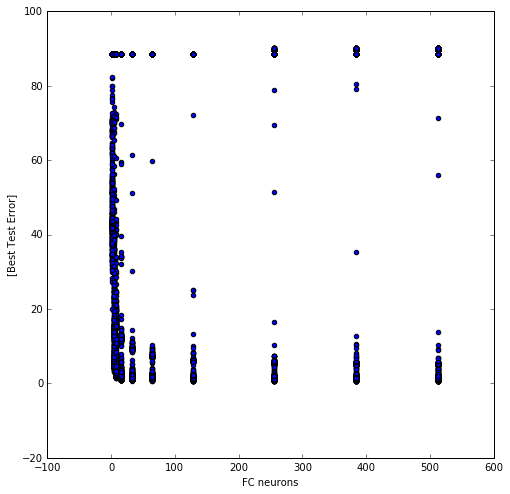

In [220]:

output = "Best Test Error"
selected_dim = "FC neurons"
condition = {}
one_dim_table = select_case(merged_table, condition, selected_dim, output, True)
merged_table.describe()

In [35]:
from math import log
def log_scale(list, base=2):
    """apply log2 function to all list item"""
    for i in range(len(list)):
        list[i] = log(list[i], base)
    return list

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# TODO: draw box plot diagram here
def draw_box_plots(table, selected_dim, output):
    fig = plt.figure(num=None, figsize=(25, 25), dpi=200, facecolor='w', edgecolor='k')
    
    ax = fig.add_subplot(111)
    x_values = sorted(set(table[selected_dim]))
    box_list = []
    selection = {}    
    for x_value in x_values:
        selection[selected_dim] = x_value
        x = select_case(table, selection, selected_dim, output)
        x = x[output].values.tolist()
        box_list.append(x)

    ax.boxplot(box_list)
    ax.set_xticklabels(x_values, fontsize=20)
    plt.ylabel(output, fontsize=20)
    plt.xlabel(selected_dim, fontsize=20)
    plt.show()

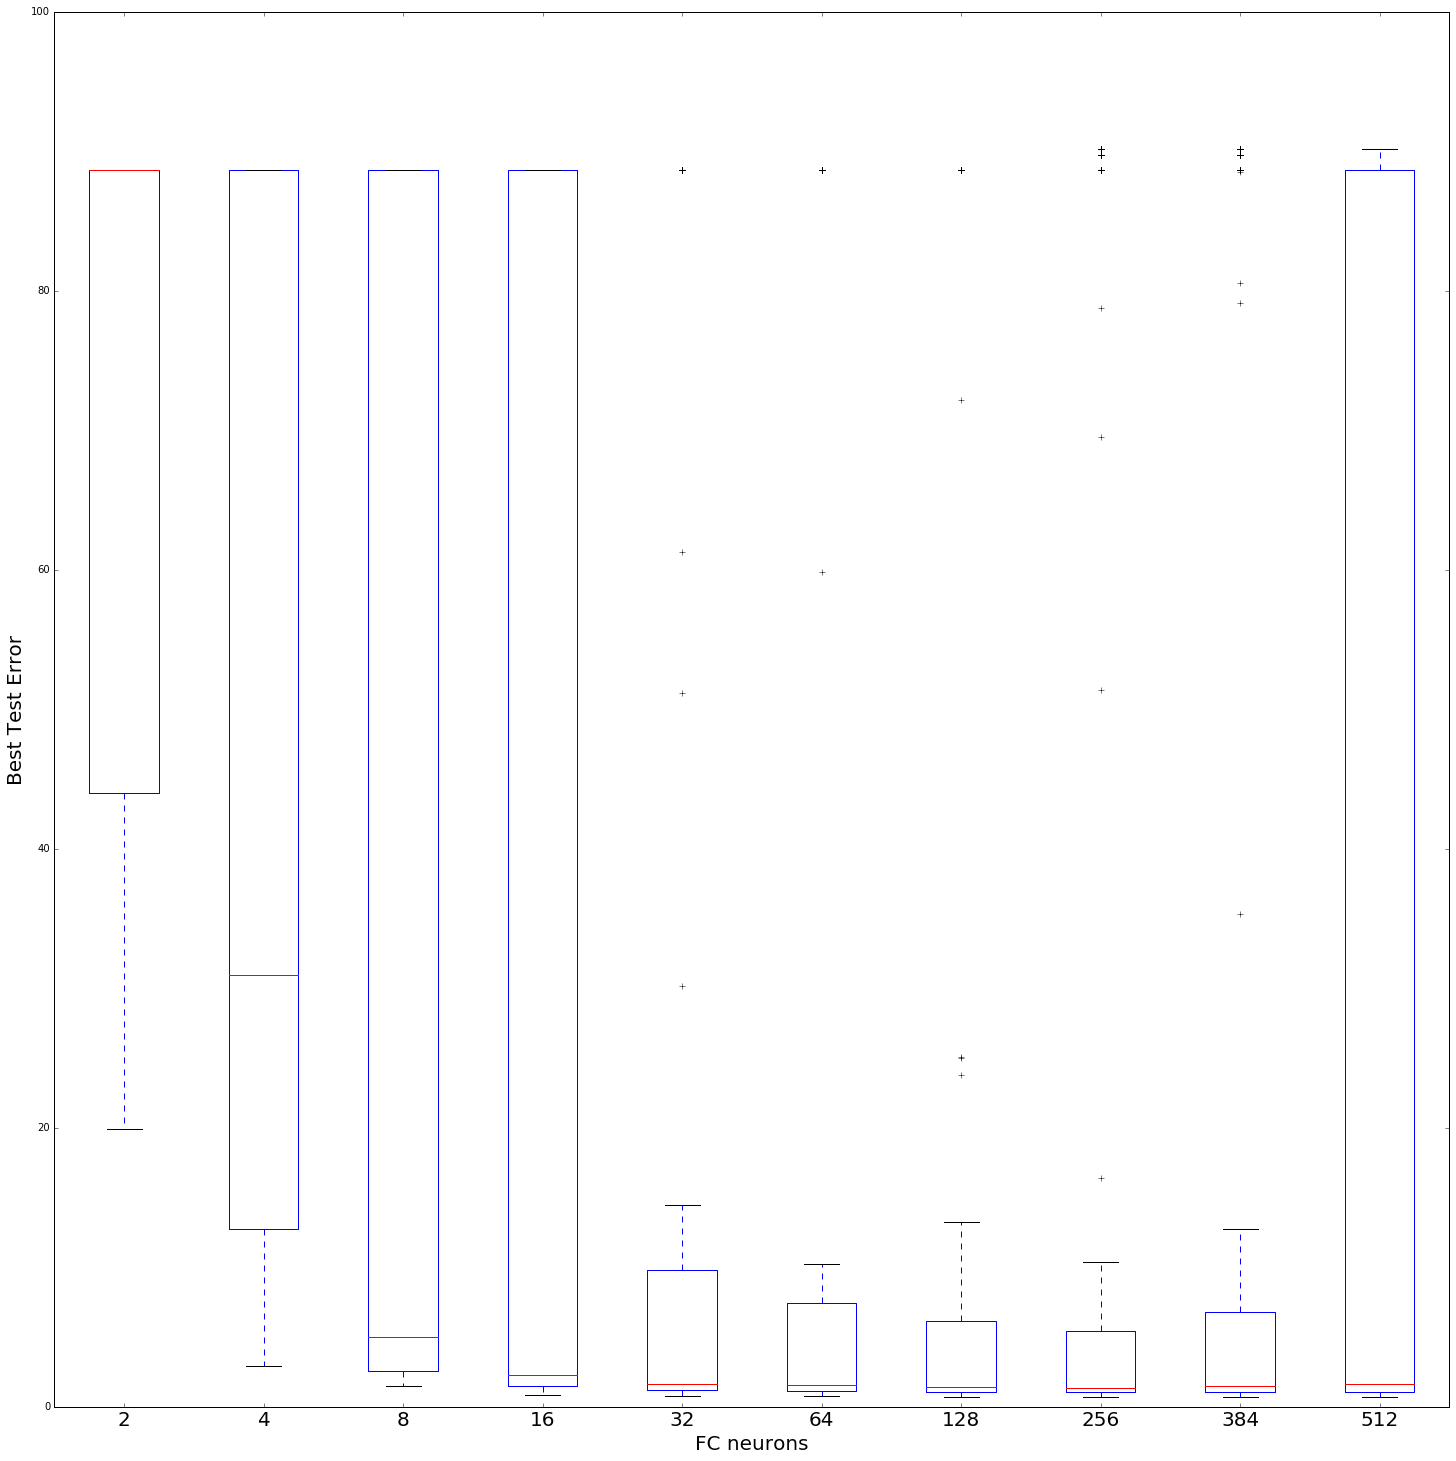

In [39]:
draw_box_plots(one_dim_table, selected_dim, output)

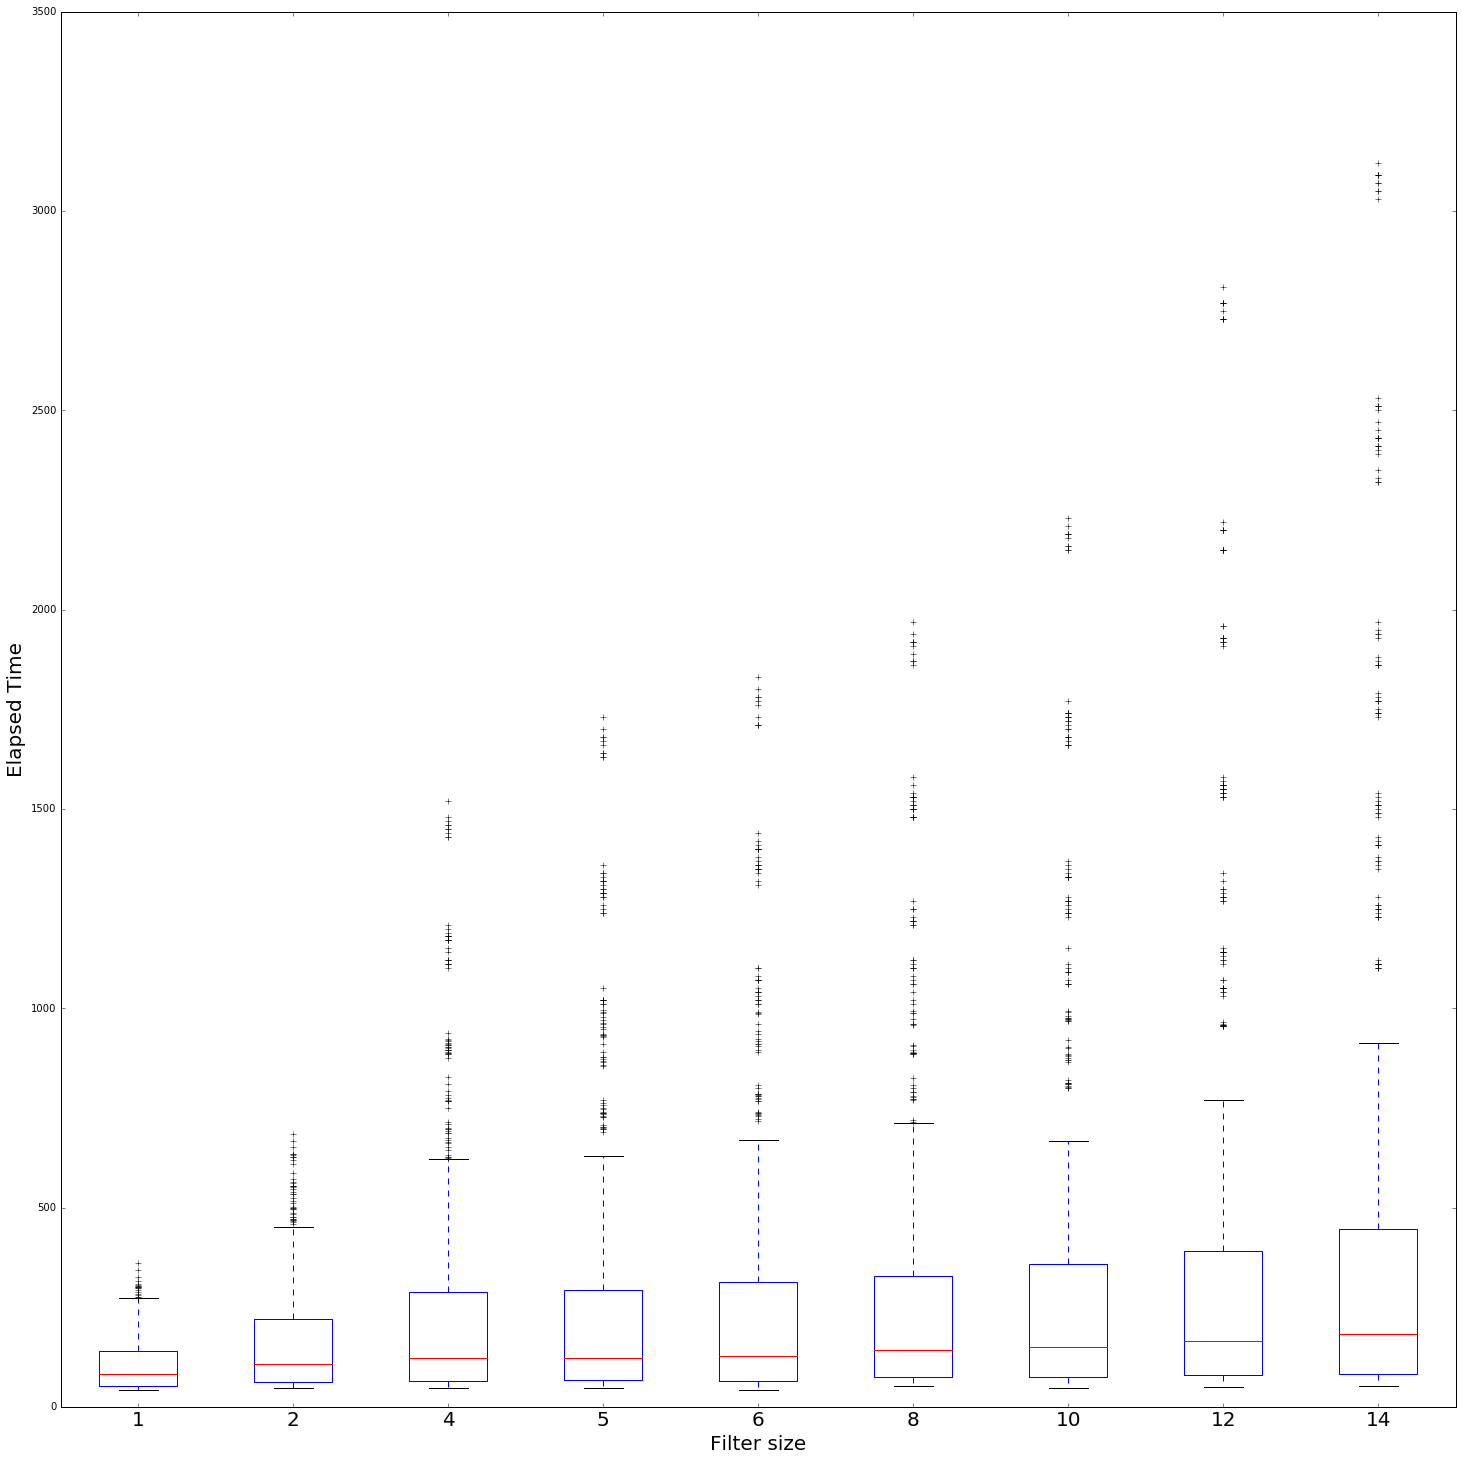

In [51]:
output = "Elapsed Time"
selected_dim = "Filter size"
draw_box_plots(one_dim_table, selected_dim, output)

In [319]:
def draw_summary_plot(table, selected_dim):
    output = "Best Test Error"
    fig = plt.figure(num=None, figsize=(25, 25), dpi=150, facecolor='w', edgecolor='k')
    
    subplot = fig.add_subplot(211)
    x_values = sorted(set(table[selected_dim]))
    box_list = []
    best_list = [2]
    best_time_list = [0]
    worst_time_list = [0]
    mean_time_list = [0]
    selection = {}    
    for x_value in x_values:
        selection[selected_dim] = x_value
        #print selection
        x = select_case(table, selection, selected_dim, output)
        #print len(x[output])
        best_value = min(x[output])
        worst_value = max(x[output])
        #print x[output]
        # find the appropriate elapsed time
        mean_time = x["Elapsed Time"].mean()
        mean_time_list.append(mean_time)
        #print mean_time
        best_time = x[x[output] == best_value]["Elapsed Time"]
        best_time = best_time.values[0]
        best_time_list.append(best_time)

        worst_time = x["Elapsed Time"].max()      
        worst_time_list.append(worst_time)        
        
        x = log_scale(x[output].values.tolist(), 10)
        
        best_list.append(log(best_value, 10))
        box_list.append(x)
    
    #print(best_list)
    #print(len(box_list))
    subplot2 = subplot.twinx()
    subplot.boxplot(box_list)
    subplot2.plot(best_list, color="black", linestyle='--', marker='o', label="Best Test Error")

    subplot.set_xticklabels(x_values, fontsize=20)
    subplot.set_xlim([0, 11])
    plt.ylabel("log10(" + output + ")", fontsize=20)
    
    plt.legend(loc="best")
    
    subplot3 = fig.add_subplot(212)
    subplot3.plot(best_time_list, color="black", linestyle='--', marker='o', label="Training Time of Best Test Error")
    #subplot4 = subplot3.twinx()
    subplot3.plot(mean_time_list, color="red", linestyle='-', marker='x', label="Mean Training Time")
    #subplot5 = subplot4.twinx()
    subplot3.plot(worst_time_list, color="blue", linestyle='-', marker='*', label="Max Training Time")
    subplot3.set_xlim([0, 11])
    if selected_dim == "Filter size":
        subplot3.set_xticklabels([], fontsize=20)
    else:
        subplot3.set_xticklabels(["0", "4", "16", "64", "256", "512"], fontsize=20) 
    #print(x_values)
    
    subplot.xaxis.grid()
    subplot.yaxis.grid()
    subplot3.xaxis.grid()
    subplot3.yaxis.grid()
    
    plt.ylabel("Elapsed Time", fontsize=20)
    plt.xlabel(selected_dim, fontsize=20)
    plt.legend(loc="best")    
    file_name = "summary-" + selected_dim + ".png"
    file_name = file_name.replace(" ", "_")
    fig.savefig(file_name, format='png', dpi=200, show=False)
    plt.show()

In [390]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

def draw_summary_plot(table, selected_dim):
    output = "Best Test Error"
    fig = plt.figure(num=None, figsize=(25, 25), dpi=150, facecolor='w', edgecolor='k')
    
    
    x_values = sorted(set(table[selected_dim]))
    error_box_list = []
    best_error_list = [100]
    time_box_list = []
    selection = {}
    best_time_list = [0]
    for x_value in x_values:
        selection[selected_dim] = x_value
        #print selection
        x = select_case(table, selection, selected_dim, output)
        #print len(x[output])
        
        best_error_value = min(x[output])
        best_error_list.append(best_error_value)
        #print x[output]
        # find the appropriate elapsed time
        time_box_values = x["Elapsed Time"].values.tolist()
        time_box_list.append(time_box_values)

        best_time = x[x[output] == best_error_value]["Elapsed Time"]
        best_time = best_time.values[0]
        best_time_list.append(best_time)
        
        error_box_values = x[output].values.tolist()
        logscale_box = log_scale(error_box_values, 10)        
        error_box_list.append(logscale_box)
    
    #print(len(time_box_list))
    #print(len(box_list))
    subplot = fig.add_subplot(211)
    subplot.boxplot(error_box_list) # test error box plot
    '''
    for item in ([subplot.title, subplot.xaxis.label, subplot.yaxis.label] +
             subplot.get_xticklabels() + subplot.get_yticklabels()):
        item.set_fontsize(20)
    '''
    subplot2 = subplot.twinx()
    subplot.set_ylim([log(0.5, 10), log(100, 10)])
    subplot.set_yticklabels([])
    #print(x_values)
    #print(best_list)
    subplot2.semilogy(best_error_list, color="black", linestyle='--', marker='o', label="Best Test Error")
    subplot2.grid(True)
    subplot2.set_ylim([0.5, 100])
    subplot.set_xticklabels(x_values)
    subplot.set_xlim([0, 11])
    plt.ylabel(output)
    
    plt.legend(loc="best")
    
    subplot3 = fig.add_subplot(212)
    subplot3.plot(best_time_list, color="black", linestyle='--', marker='o', label="Training Time of Best Test Error")
    
    #subplot4 = subplot3.twinx()
    subplot3.boxplot(time_box_list)
    subplot3.set_xlim([0, 11])
    
    subplot3.set_xticklabels([])
    
    #print(x_values)
    
    subplot.xaxis.grid()
    #subplot.yaxis.grid()
    subplot3.xaxis.grid()
    subplot3.yaxis.grid()
    
    plt.ylabel("Elapsed Time")
    plt.xlabel(selected_dim)
    plt.legend(loc="best")    
    file_name = "summary-" + selected_dim + ".png"
    file_name = file_name.replace(" ", "_")
    fig.savefig(file_name, format='png', dpi=200, show=False)
    plt.show()

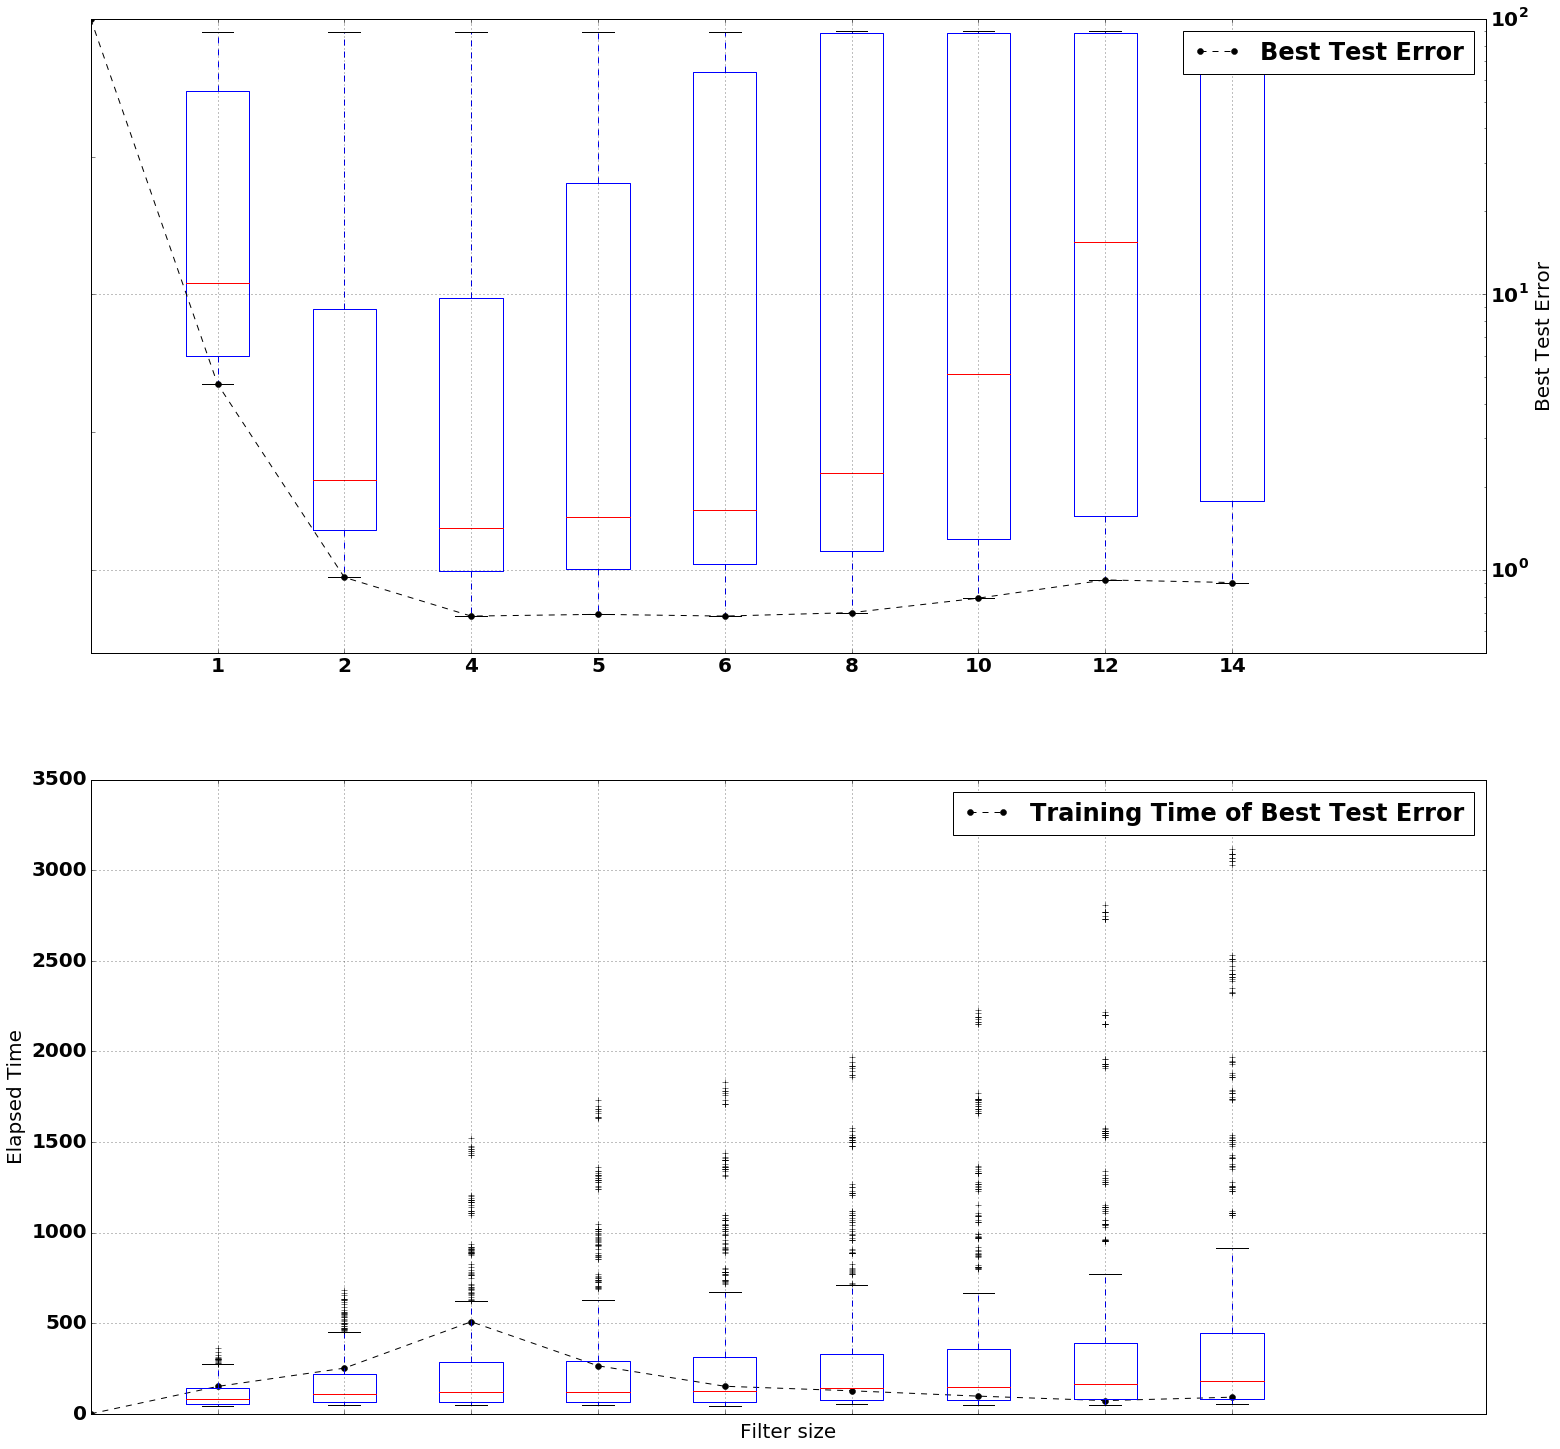

In [394]:
selected_dim = "Filter size"#"Conv1 depth"# "FC neurons" # 
draw_summary_plot(merged_table, selected_dim)

In [ ]:
# simple test case for get_one_dim() 
output = "Test Error"
selected_dim = "FC neurons"

for i in range(2):
    test = {"Filter size" : i+1, "Conv1 depth": 32, "Conv2 depth": 64}
    table = get_one_dim(test, selected_dim, output)
    print(table.head(10))

In [ ]:
import os

In [ ]:
def draw_n_by_n_plots(fixed, x_axis, y_axis, selected_dim, output, show_fig=False, save_fig=True, to_log_scale=True):
    condition = {}
    condition[fixed["name"]] = fixed["value"]

    fig = plt.figure(num=None, figsize=(50, 50), dpi=200, facecolor='w', edgecolor='k')
    fig.suptitle("Fixed hyperparameter - " + fixed["name"] + ": " + str(fixed["value"]), fontsize=50)
    fig_index = 1
    
    if output is "Elapsed Time":
        # for fixed output range setting
        condition[x_axis["name"]] = max(x_axis["values"])
        condition[y_axis["name"]] = max(y_axis["values"])
        one_dim_table = get_one_dim(condition, selected_dim, output)
        y_range = [0, max(one_dim_table[output])]      
    elif output is "Test Error":
        y_range = [0, 100]
        
    x_axis_length = len(x_axis["values"])
    y_axis_length = len(y_axis["values"])
    for i in range(x_axis_length):
        condition[x_axis["name"]] = x_axis["values"][i]
        for j in range(y_axis_length):
            subplot = fig.add_subplot(x_axis_length, y_axis_length, fig_index)
            fig_index += 1
            condition[y_axis["name"]] = y_axis["values"][j]
            
            one_dim_table = get_one_dim(condition, selected_dim, output)
          
            x_col_name = selected_dim
            # To show log scale
            if to_log_scale:
                logscale_col = "log2(" + selected_dim + ")"
                x_col_name = logscale_col
                
            subplot.plot(one_dim_table[x_col_name], one_dim_table[output])
            title = x_axis["name"] + ":" + str(condition[x_axis["name"]]) + ", " + \
                y_axis["name"] + ":" + str(condition[y_axis["name"]])
            subplot.set_title(title)
            subplot.set_ylim(y_range)
            if j == 0:
                plt.ylabel(output)

            if j == 0:
                plt.xlabel(x_col_name)

    if show_fig:
        plt.show()
        
    if save_fig:
        working_dir = os.getcwd()
        file_name = fixed["name"] + "_" + str(condition[fixed["name"]]) + '-' + output + '.png'
        file_name = file_name.replace(" ", "_")
        output_folder = output.replace(" ", "_")
        selected_dim_folder = selected_dim.replace(" ", "_")
        #print (output_folder)
        #print (selected_dim_folder)
        try:
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
                #print(output_folder + " is created")
                
            os.chdir(output_folder)

            if not os.path.exists(selected_dim_folder):
                os.makedirs(selected_dim_folder)
                
            os.chdir(selected_dim_folder)
        except OSError as exception:
            print("folder creation error: " + str(exception))
            os.chdir(working_dir)
            
        fig.savefig(file_name, format='png', dpi=200, show=False)
        os.chdir(working_dir)
        print(file_name + " is saved successfully.")
    return

In [ ]:
# modified version (Test Error is transformated by log 10 scale)
def draw_n_by_n_plots(fixed, x_axis, y_axis, selected_dim, output, show_fig=False, save_fig=True, to_log_scale=True):
    condition = {}
    condition[fixed["name"]] = fixed["value"]

    fig = plt.figure(num=None, figsize=(50, 50), dpi=200, facecolor='w', edgecolor='k')
    fig.suptitle("Fixed hyperparameter - " + fixed["name"] + ": " + str(fixed["value"]), fontsize=50)
    fig_index = 1
    
    if output == "Elapsed Time":
        # for fixed output range setting
        condition[x_axis["name"]] = max(x_axis["values"])
        condition[y_axis["name"]] = max(y_axis["values"])
        one_dim_table = get_one_dim(condition, selected_dim, output)
        y_range = [0, max(one_dim_table[output])]      
    elif output == "Test Error":
        y_range = [log(0.01, 10), log(100, 10)]
    else:
        print("unsupported output type")
    
    x_axis_length = len(x_axis["values"])
    y_axis_length = len(y_axis["values"])
    for i in range(x_axis_length):
        condition[x_axis["name"]] = x_axis["values"][i]
        for j in range(y_axis_length):
            subplot = fig.add_subplot(x_axis_length, y_axis_length, fig_index)
            fig_index += 1
            condition[y_axis["name"]] = y_axis["values"][j]
            
            one_dim_table = get_one_dim(condition, selected_dim, output)
            # print(one_dim_table.head(10)) # for debugging 
            x_col_name = selected_dim
            # To show log scale
            if to_log_scale:
                logscale_col = "log2(" + selected_dim + ")"
                x_col_name = logscale_col
                
            subplot.plot(one_dim_table[x_col_name], one_dim_table["log10(" + output + ")"])
            title = x_axis["name"] + ":" + str(condition[x_axis["name"]]) + ", " + \
                y_axis["name"] + ":" + str(condition[y_axis["name"]])
            subplot.set_title(title)
            subplot.set_ylim(y_range)
            if j == 0:
                y_label = "log10(" + output + ")"
                plt.ylabel(y_label)

            if j == 0:
                plt.xlabel(x_col_name)

    if show_fig:
        plt.show()
    if save_fig:
        working_dir = os.getcwd()
        file_name = fixed["name"] + "_" + str(condition[fixed["name"]]) + '-' + output + '.png'
        file_name = file_name.replace(" ", "_")
        output_folder = output.replace(" ", "_")
        selected_dim_folder = selected_dim.replace(" ", "_")
        #print (output_folder)
        #print (selected_dim_folder)
        try:
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
                #print(output_folder + " is created")
                
            os.chdir(output_folder)

            if not os.path.exists(selected_dim_folder):
                os.makedirs(selected_dim_folder)
                
            os.chdir(selected_dim_folder)
        except OSError as exception:
            print("folder creation error: " + str(exception))
            os.chdir(working_dir)
            
        fig.savefig(file_name, format='png', dpi=200, show=False)
        os.chdir(working_dir)
        print(file_name + " is saved successfully.")
        
    return

In [ ]:
print os.getcwd()
filter_sizes = [2, 4, 6, 8, 10, 12, 14]

#conv1_list = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
#conv2_list = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
conv1_list = [2, 8, 32, 64, 256, 512]
conv2_list = [2, 8, 32, 64, 256, 512]
x_axis = {"name" : "Conv1 depth", "values" : conv1_list}
y_axis = {"name" : "Conv2 depth", "values" : conv2_list}
output = "Elapsed Time" #"Test Error" #
selected_dim = "FC neurons"
fixed = {"name": "Filter size", "value": 2}
draw_n_by_n_plots(fixed, x_axis, y_axis, selected_dim, output, False, True)

In [ ]:
filter_sizes = [2, 4, 6, 8, 10, 12, 14]

#conv1_list = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
#conv2_list = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
conv1_list = [2, 8, 32, 64, 256, 512]
conv2_list = [2, 8, 32, 64, 256, 512]
x_axis = {"name" : "Conv1 depth", "values" : conv1_list}
y_axis = {"name" : "Conv2 depth", "values" : conv2_list}
outputs = ["Elapsed Time", "Test Error"]
selected_dim = "FC neurons"

for f in filter_sizes:
    for output in outputs:
        fixed = {"name": "Filter size", "value": f}
        draw_n_by_n_plots(fixed, x_axis, y_axis, selected_dim, output, False, True)

In [ ]:
filter_sizes = [1, 2, 4, 6, 8, 10, 12, 14]
conv1_list = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
conv2_list = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
fc_list = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
conv1_list = [2, 8, 32, 64, 256, 512]
conv2_list = [2, 8, 32, 64, 256, 512]
fc_list = [2, 8, 32, 128, 384, 512]
x_axis = {"name" : "Conv1 depth", "values" : conv1_list}
y_axis = {"name" : "Conv2 depth", "values" : conv2_list}
outputs = ["Elapsed Time", "Test Error"]
selected_dim = "Filter size"

for fc in fc_list:
    for output in outputs:
        fixed = {"name": "FC neurons", "value": fc}
        draw_n_by_n_plots(fixed, x_axis, y_axis, selected_dim, output, False, True, False)

In [ ]:
filter_sizes = [1, 2, 4, 6, 8, 10, 12, 14]
conv1_list = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
conv2_list = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
fc_list = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
conv2_list = [2, 8, 32, 64, 256, 512]
fc_list = [2, 8, 32, 64, 256, 512]
filter_sizes = [2, 4, 6, 8, 10, 14]
#conv2_list = [2, 8, 32, 64, 256, 512]
#fc_list = [2, 8, 32, 128, 384, 512]
x_axis = {"name" : "Filter size", "values" : filter_sizes}
y_axis = {"name" : "FC neurons", "values" : fc_list}
outputs = ["Elapsed Time", "Test Error"]
selected_dim = "Conv1 depth"

for conv2 in conv2_list:
    for output in outputs:
        fixed = {"name": "Conv2 depth", "value": conv2}
        draw_n_by_n_plots(fixed, x_axis, y_axis, selected_dim, output, False, True, True)

In [ ]:
filter_sizes = [1, 2, 4, 6, 8, 10, 12, 14]
conv1_list = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
conv2_list = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
fc_list = [2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
conv1_list = [2, 8, 32, 64, 256, 512]
fc_list = [2, 8, 32, 64, 256, 512]
filter_sizes = [2, 4, 6, 8, 10, 14]
#conv2_list = [2, 8, 32, 64, 256, 512]
#fc_list = [2, 8, 32, 128, 384, 512]
x_axis = {"name" : "Filter size", "values" : filter_sizes}
y_axis = {"name" : "FC neurons", "values" : fc_list}
outputs = ["Elapsed Time", "Test Error"]
selected_dim = "Conv2 depth"

for conv1 in conv1_list:
    for output in outputs:
        fixed = {"name": "Conv1 depth", "value": conv1}
        draw_n_by_n_plots(fixed, x_axis, y_axis, selected_dim, output, False, True, True)